In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15
import seaborn as sns

import os
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm ,tnrange

In [2]:
train_data = pd.read_csv('train.csv')

print(train_data.shape)

train_data.head()

(381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
test_data = pd.read_csv('test.csv')

print(test_data.shape)

test_data.head()

(127037, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [4]:
x = train_data[~train_data.iloc[:,1:].duplicated(keep = 'first')]
train_data = train_data[~train_data.id.isin(x[x.iloc[:,1:-1].duplicated(keep = False)].id)]

In [5]:
def nullColumns(train_data):
    
    list_of_nullcolumns =[]
    
    for column in train_data.columns:
        
        total= train_data[column].isna().sum()
        
        try:
            
            if total !=0:
                
                print('Total Na values is {0} for column {1}' .format(total, column))
                
                list_of_nullcolumns.append(column)
        
        except:
            
            print(column,"-----",total)
    
    print('\n')
    
    return list_of_nullcolumns


def percentMissingFeature(data):
    
    data_na = (data.isnull().sum() / len(data)) * 100
    
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    
    return data_na


def plotMissingFeature(data_na):
    
    f, ax = plt.subplots(figsize=(15, 12))
    
    plt.xticks(rotation='90')
    
    if(data_na.empty ==False):
        
        sns.barplot(x=data_na.index, y=data_na)
        
        plt.xlabel('Features', fontsize=15)
        
        plt.ylabel('Percent of missing values', fontsize=15)
        
        plt.title('Percent missing data by feature', fontsize=15)

In [6]:
print('train data')

print(nullColumns(train_data))

print(percentMissingFeature(train_data))

print('\n')

print('test_data')

print(nullColumns(test_data))

print(percentMissingFeature(test_data))

train data


[]
Series([], dtype: float64)


test_data


[]
Series([], dtype: float64)


In [7]:
train_data.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381003.000000,381003.000000,381003.000000,381003.000000,381003.000000,381003.000000,381003.000000,381003.000000,381003.000000
mean,190551.691210,38.821301,0.997869,26.387934,0.458338,30572.161293,112.039449,154.347871,0.122458
std,110016.408515,15.512765,0.046116,13.230202,0.498262,17209.241144,54.202864,83.669945,0.327815
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95275.500000,25.000000,1.000000,15.000000,0.000000,24412.000000,29.000000,82.000000,0.000000
50%,190552.000000,36.000000,1.000000,28.000000,0.000000,31673.000000,133.000000,154.000000,0.000000
75%,285826.500000,49.000000,1.000000,35.000000,1.000000,39405.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


Text(0.5, 1.0, 'Response')

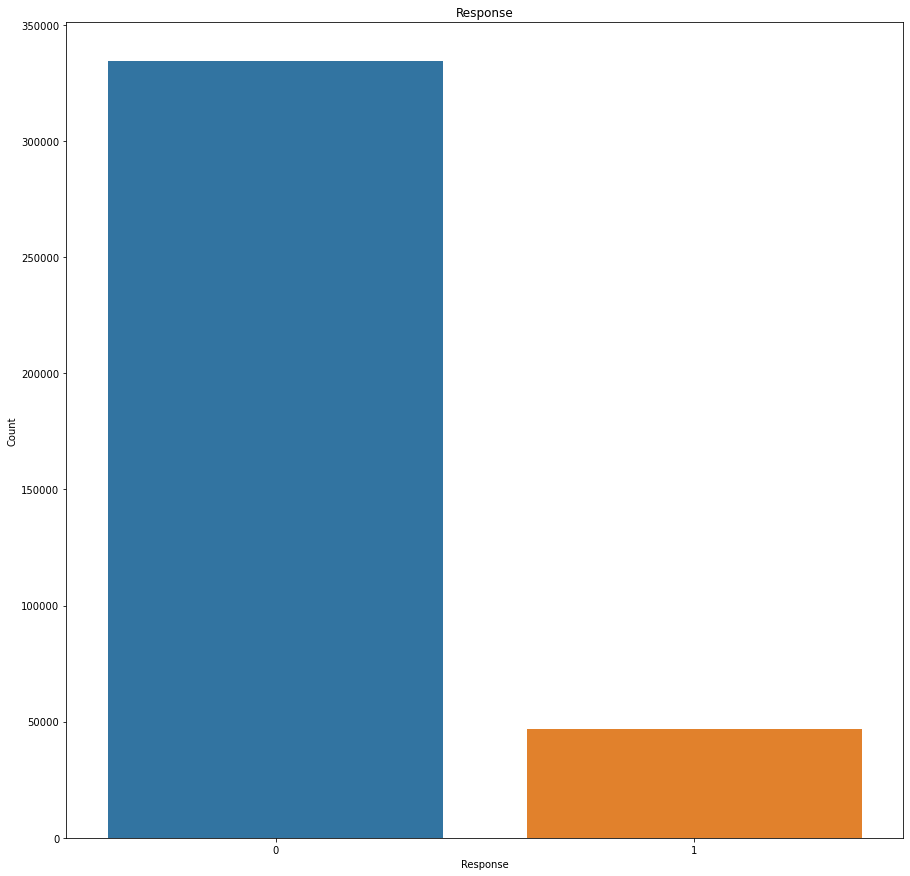

In [8]:
response = train_data.loc[:,"Response"].value_counts().rename('Count')
plt.xlabel("Response")
plt.ylabel('Count')
sns.barplot(response.index , response.values).set_title('Response')

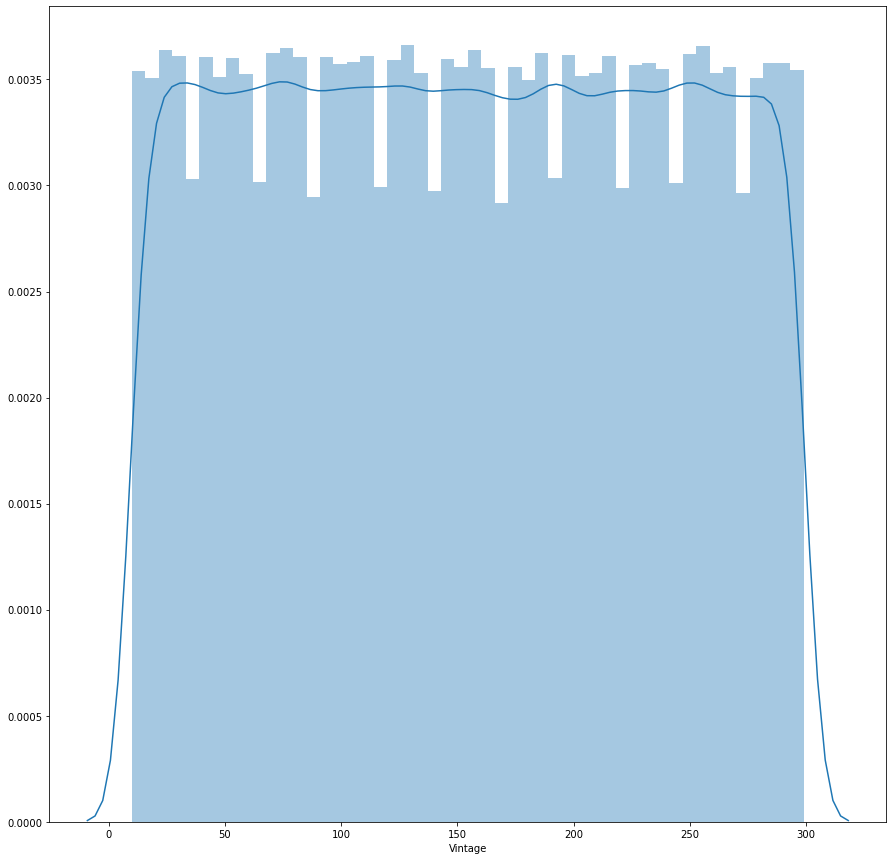

In [9]:
sns.distplot(train_data['Vintage'])

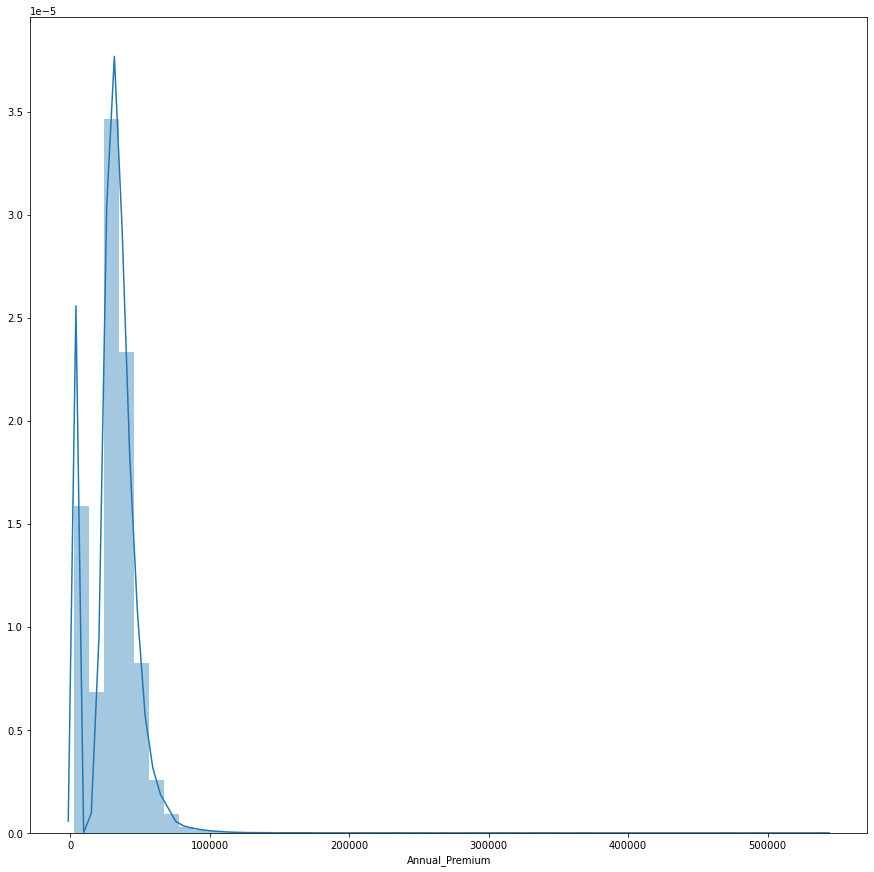

In [10]:
sns.distplot(train_data['Annual_Premium'])

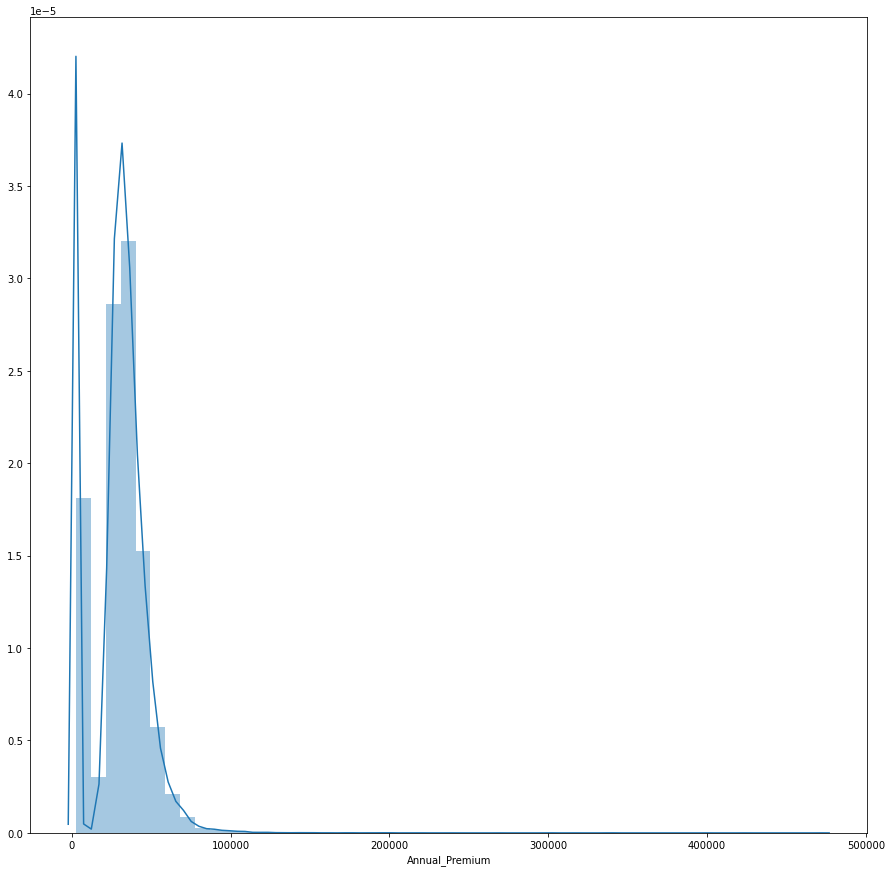

In [11]:
sns.distplot(test_data['Annual_Premium'])

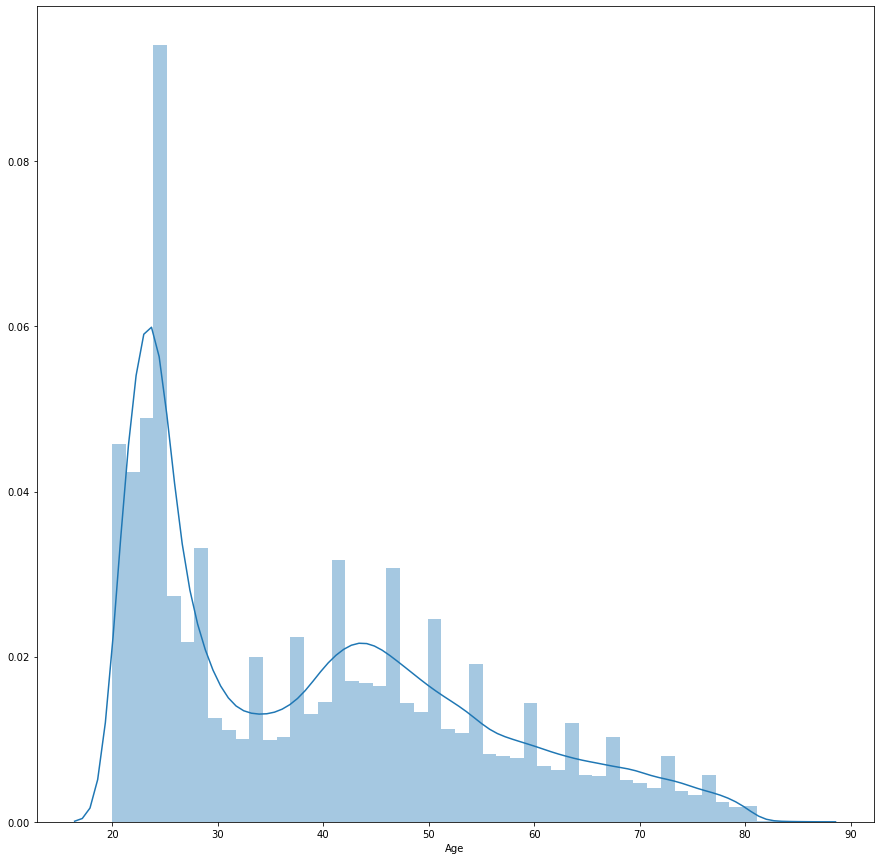

In [12]:
sns.distplot(train_data['Age'])

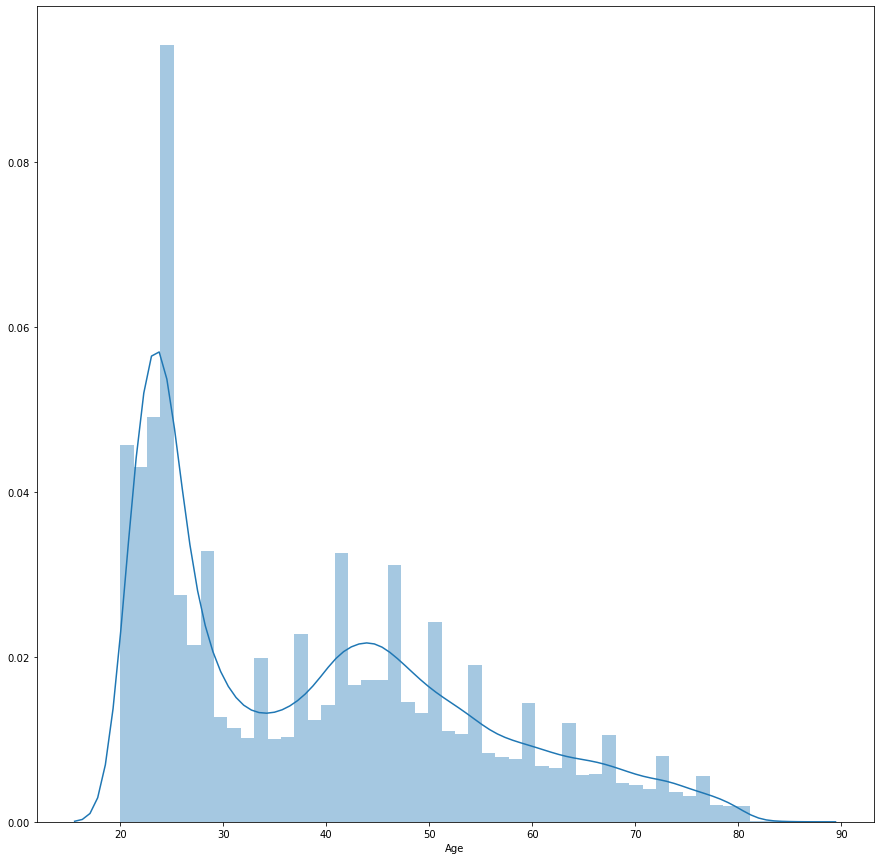

In [13]:
sns.distplot(test_data['Age'])

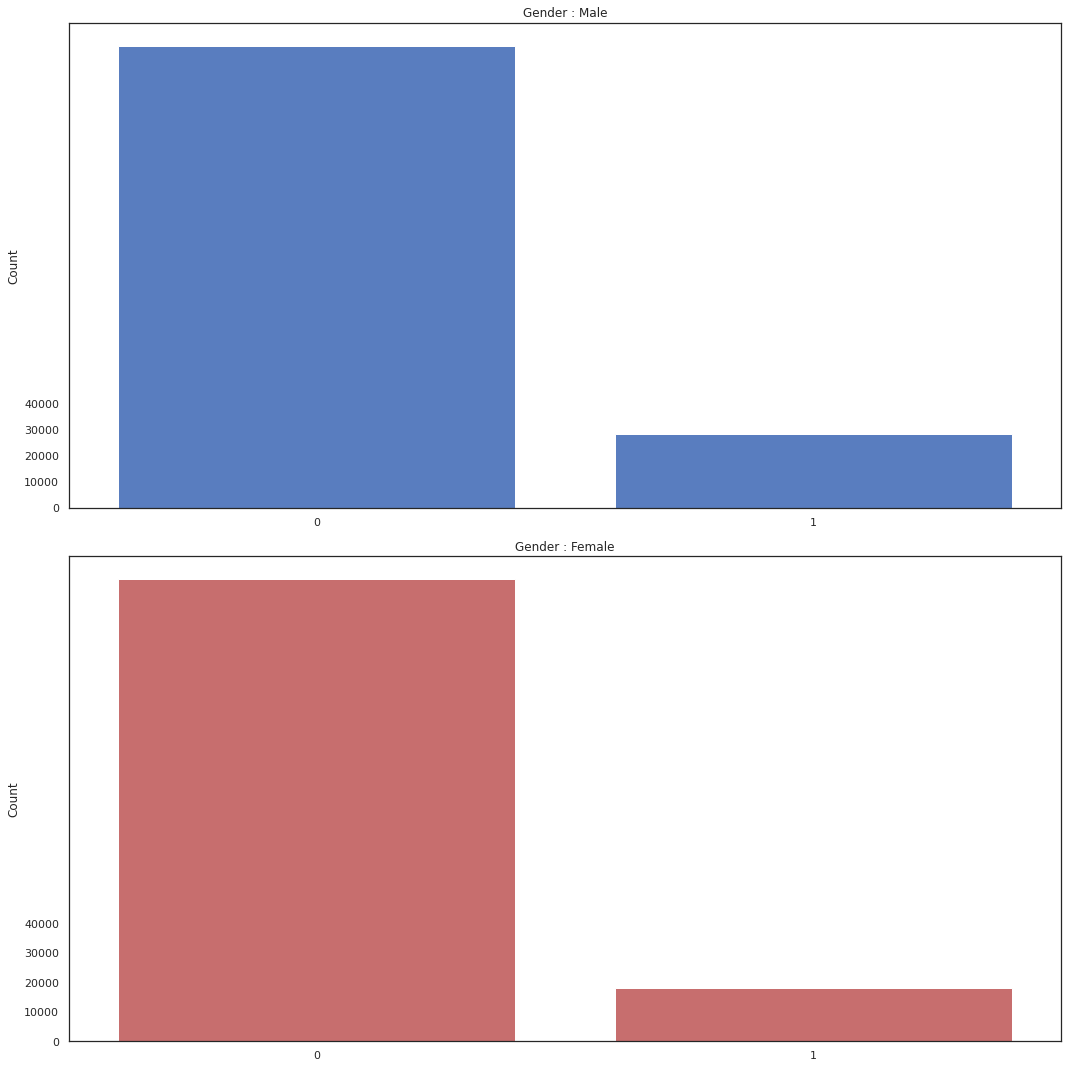

In [14]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 1, figsize=(15, 15))

male = train_data[train_data['Gender'] =='Male']["Response"].value_counts().rename('Count')

female = train_data[train_data['Gender'] =='Female']["Response"].value_counts().rename('Count')

sns.barplot(male.index,male,  color="b", ax=axes[0]).set_title('Gender : Male')

sns.barplot(female.index,female,   color="r", ax=axes[1]).set_title('Gender : Female')

plt.setp(axes, yticks = np.arange(0,50000,10000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=0)

plt.tight_layout()

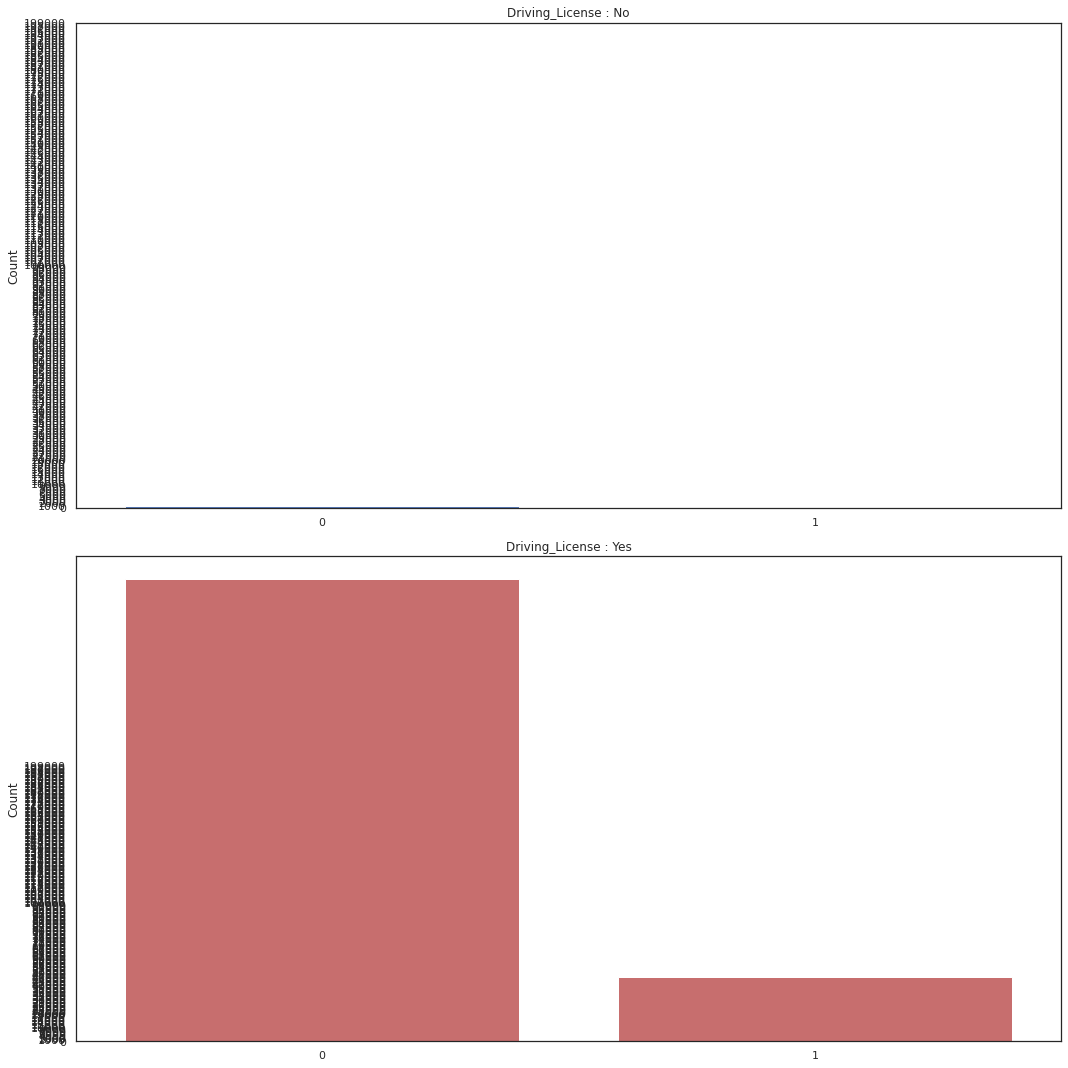

In [15]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 1, figsize=(15, 15))

dl0 = train_data[train_data['Driving_License'] ==0]["Response"].value_counts().rename('Count')

dl1 = train_data[train_data['Driving_License'] ==1]["Response"].value_counts().rename('Count')

sns.barplot(dl0.index,dl0,  color="b", ax=axes[0]).set_title('Driving_License : No')

sns.barplot(dl1.index,dl1,   color="r", ax=axes[1]).set_title('Driving_License : Yes')

plt.setp(axes, yticks = np.arange(0,200000,1000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=0)

plt.tight_layout()

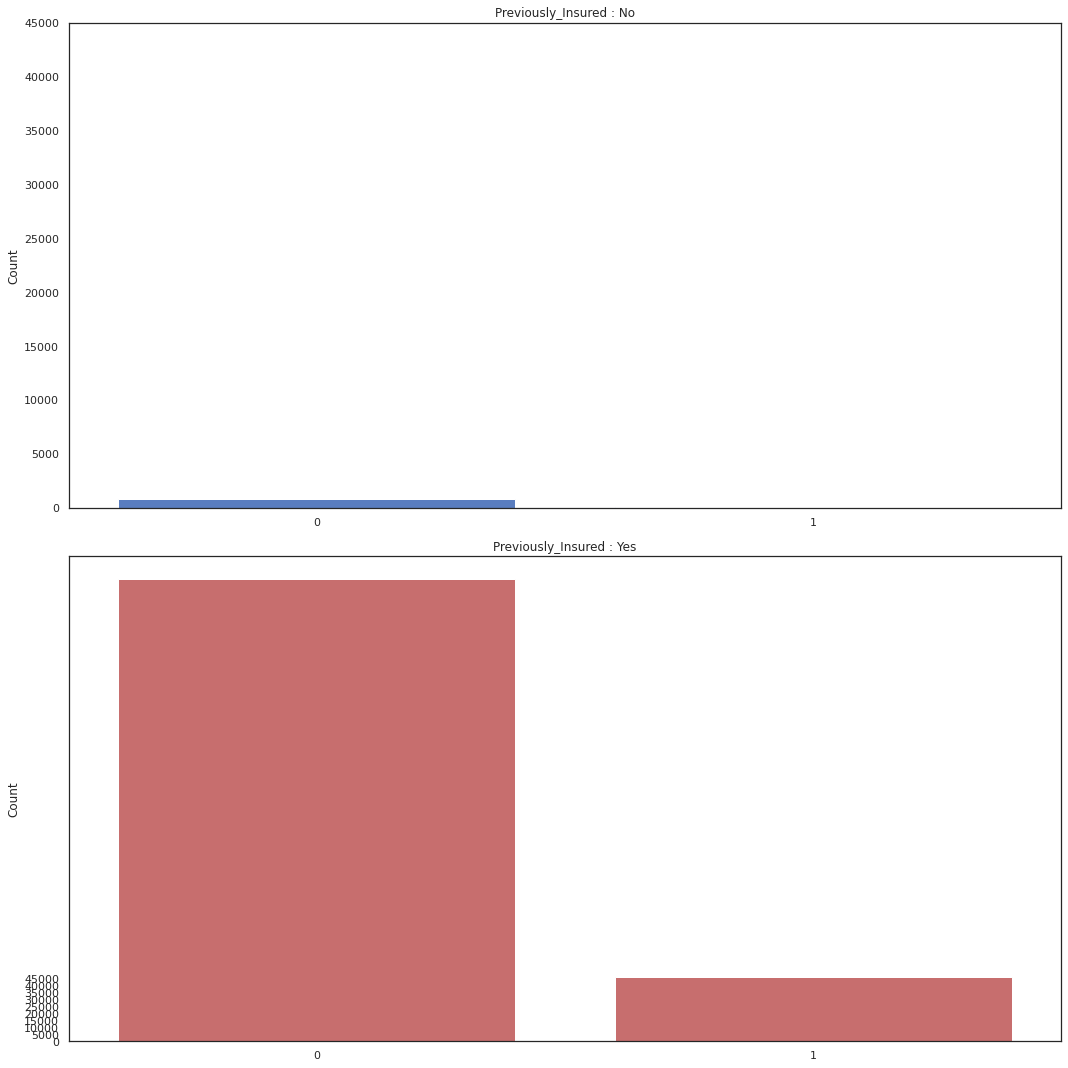

In [16]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 1, figsize=(15, 15))

pi0 = train_data[train_data['Previously_Insured'] ==0]["Response"].value_counts().rename('Count')

pi1 = train_data[train_data['Previously_Insured'] ==1]["Response"].value_counts().rename('Count')

sns.barplot(dl0.index,dl0,  color="b", ax=axes[0]).set_title('Previously_Insured : No')

sns.barplot(dl1.index,dl1,   color="r", ax=axes[1]).set_title('Previously_Insured : Yes')

plt.setp(axes, yticks = np.arange(0,50000,5000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=0)

plt.tight_layout()


In [17]:
train_data['Policy_Sales_Channel'].astype(str)+'_'+train_data['Region_Code'].astype(str)

0          26.0_28.0
1           26.0_3.0
2          26.0_28.0
3         152.0_11.0
4         152.0_41.0
             ...    
381104     26.0_26.0
381105    152.0_37.0
381106    160.0_30.0
381107    124.0_14.0
381108     26.0_29.0
Length: 381003, dtype: object

In [18]:
train_data['Policy_Region'] = train_data['Policy_Sales_Channel'].astype(str)+'_'+train_data['Region_Code'].astype(str)

test_data['Policy_Region'] = test_data['Policy_Sales_Channel'].astype(str)+'_'+test_data['Region_Code'].astype(str)

train_data['Vehicle_Age_License'] = train_data['Vehicle_Age'].astype(str)+'_'+train_data['Driving_License'].astype(str)

test_data['Vehicle_Age_License'] = test_data['Vehicle_Age'].astype(str)+'_'+test_data['Driving_License'].astype(str)

In [19]:
cat_features = ['Gender','Driving_License','Region_Code','Previously_Insured',
                'Vehicle_Damage','Policy_Sales_Channel','Policy_Region',
                'Vehicle_Age','Vintage','Annual_Premium','Vehicle_Age_License']

cont_features = ['Age']

label = 'Response'

In [20]:
def encode_cat_cols(train, test, cat_cols): #target

    train_df = train_data.copy()
    
    test_df = test_data.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}

    for col in cat_cols:
        
        if col!= 'Vehicle_Age':
        
            le = LabelEncoder()

            le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())

            train_df[col] = le.transform(train_df[[col]])

            test_df[col] = le.transform(test_df[[col]])

            le_dict[col] = le
        
    train_df['Vehicle_Age'] = train_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})
    
    test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})

    le = LabelEncoder()
    
    train_df[label] = le.fit_transform(train_df[[label]])
    
    le_dict[label] = le
    
    
    return train_df, test_df, le_dict

In [21]:
train_df, test_df, le_dict = encode_cat_cols(train_data,test_data,cat_features)

In [22]:
train_df = train_df[~train_df.Policy_Sales_Channel.isin(list(set(train_df.Policy_Sales_Channel)-set(test_df.Policy_Sales_Channel)))]

#test_df.loc[(test_df.Policy_Sales_Channel.isin(list(set(test_df.Policy_Sales_Channel) - set(train_df.Policy_Sales_Channel)))),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==137),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==136),'Policy_Sales_Channel'] = -1

In [23]:
#Used only for XgBoost and LightGBM
#test_df.loc[(test_df.Annual_Premium.isin(list(set(test_df.Annual_Premium) - set(train_df.Annual_Premium)))),'Annual_Premium'] = -1

In [24]:
train_df['train'] = 1

test_df['train'] = 0

combined_data = pd.concat([train_df,test_df],axis =0).reset_index(drop = True).copy()

In [25]:
premium_discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

combined_data['Premium_Bins'] =premium_discretizer.fit_transform(combined_data['Annual_Premium'].values.reshape(-1,1)).astype(int)

age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

combined_data['Age_Bins'] =age_discretizer.fit_transform(combined_data['Age'].values.reshape(-1,1)).astype(int)

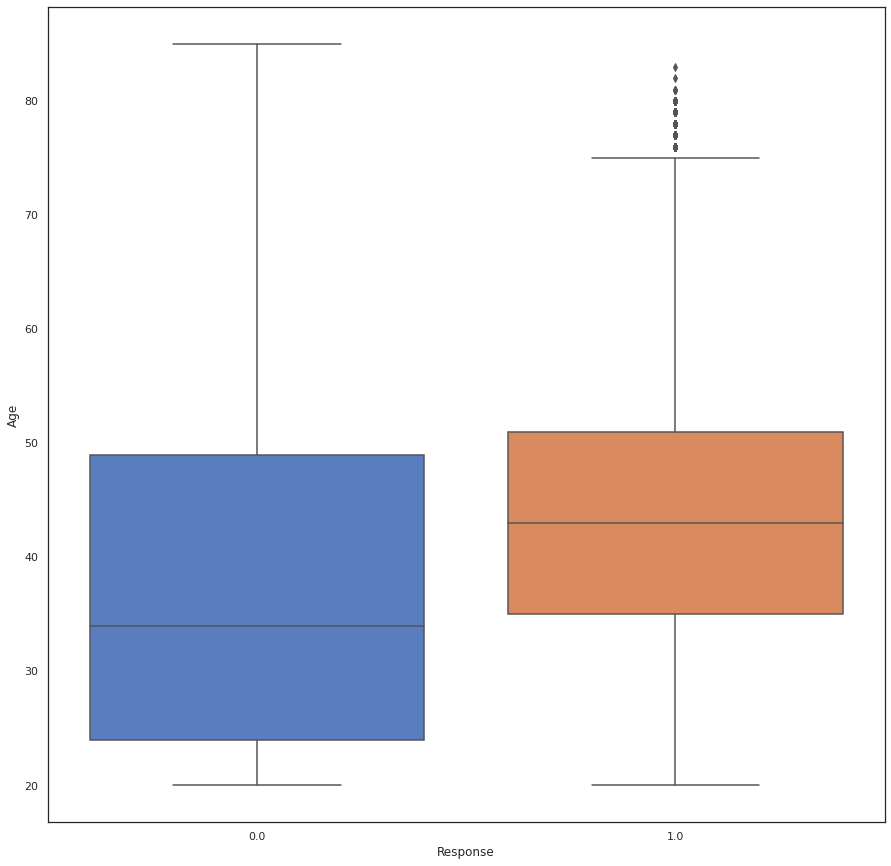

In [26]:
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Age'])

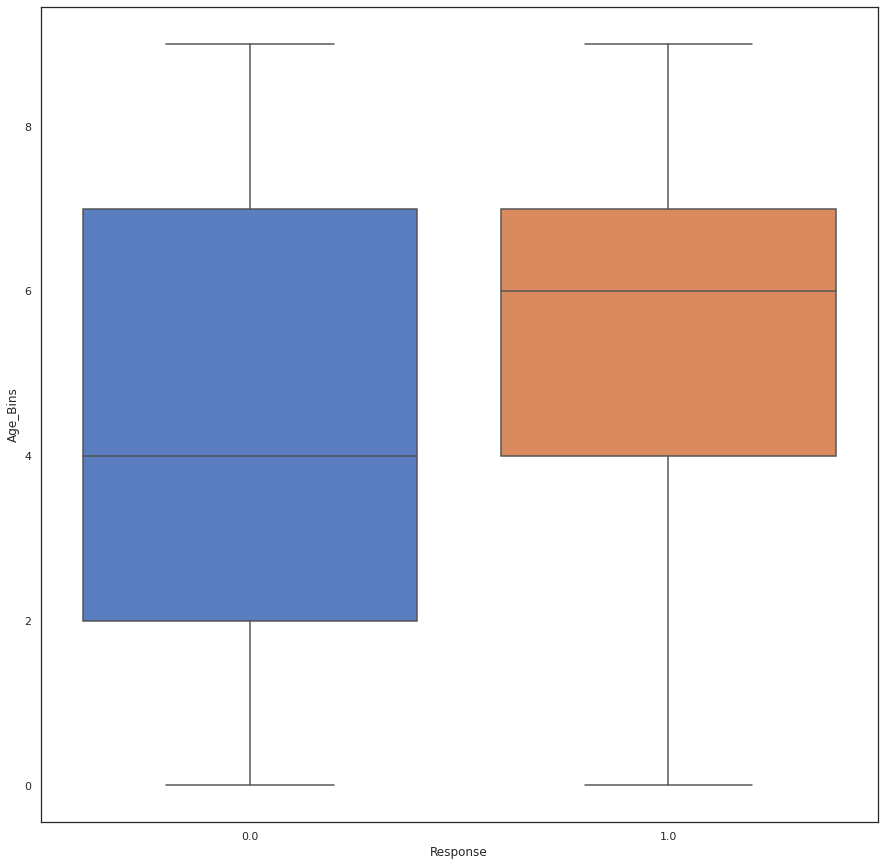

In [27]:


# Age Bin demarcates two classses better(compare the follwing graph with the above one)
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Age_Bins'])



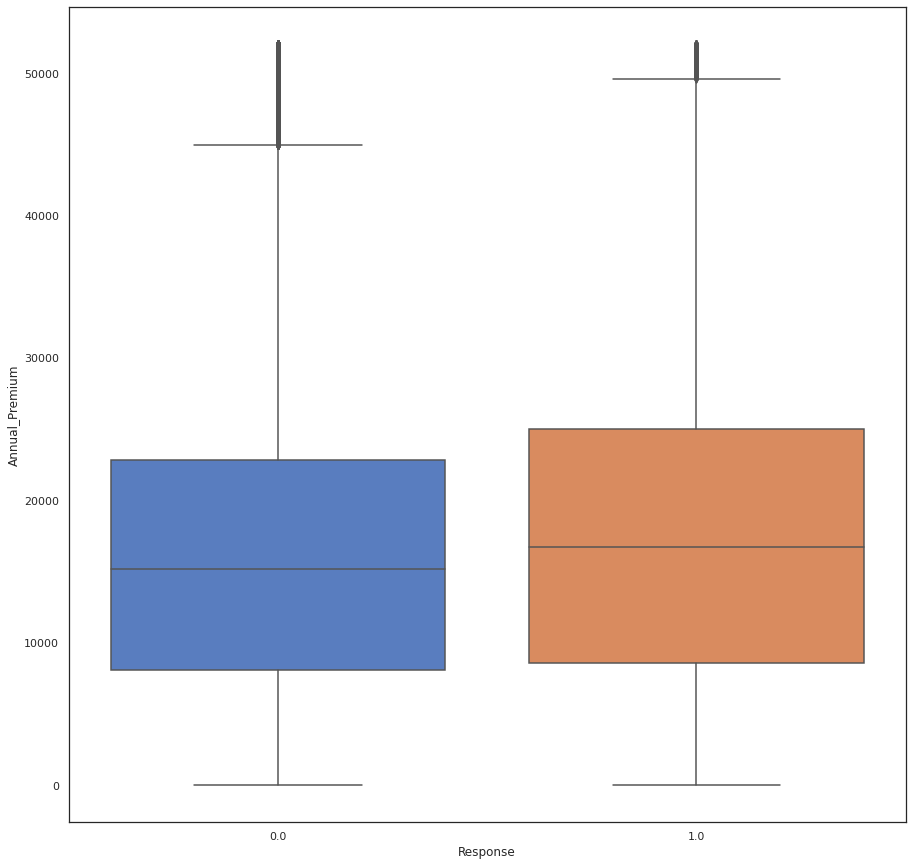

In [28]:
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Annual_Premium'])

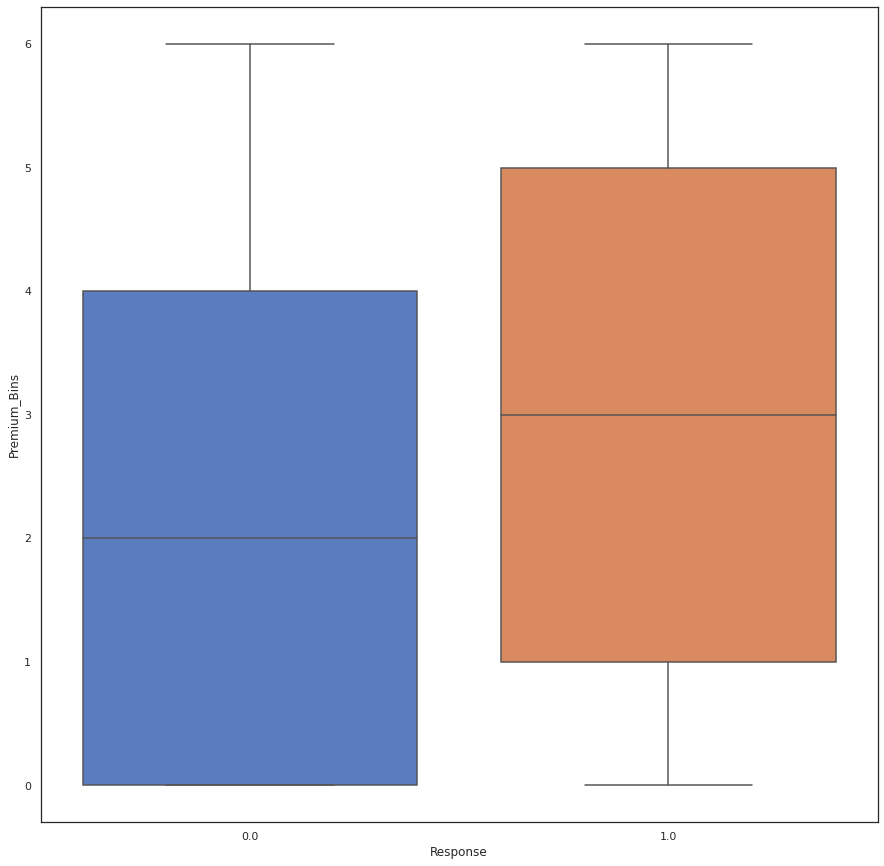

In [29]:
# the same can be seen after binning annual premium
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Premium_Bins'])

In [30]:
gender_counts = combined_data['Gender'].value_counts().to_dict()

combined_data['Gender_Counts'] = combined_data['Gender'].map(gender_counts)

region_counts = combined_data['Region_Code'].value_counts().to_dict()

combined_data['Region_counts'] = combined_data['Region_Code'].map(region_counts)

vehicle_age_counts = combined_data['Vehicle_Age'].value_counts().to_dict()

combined_data['Vehicle_Age_Counts'] = combined_data['Vehicle_Age'].map(vehicle_age_counts)

In [31]:
combined_data['Nunq_Policy_Per_Region'] = combined_data.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique') 

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] = combined_data.groupby('Region_Code')['Annual_Premium'].transform('std').fillna(-1) 

combined_data['Nunq_Region_Per_Premium'] = combined_data.groupby('Annual_Premium')['Region_Code'].transform('nunique')

# 1230.45 can be split into “1230” and “45”. LGBM cannot see these pieces on its own, you need to split them.
combined_data['SDev_Annual_Premium_Per_Region_Code_dec'] = combined_data['SDev_Annual_Premium_Per_Region_Code_int'] %1

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] =combined_data['SDev_Annual_Premium_Per_Region_Code_int'].astype(int)


combined_data['Avg_Policy_Region_Age'] = combined_data.groupby(['Policy_Region'])['Age'].transform('mean')

combined_data['Avg_Policy_Region_Premium'] = combined_data.groupby(['Policy_Region'])['Annual_Premium'].transform('mean') 

combined_data['Avg_Region_Premium'] = combined_data.groupby(['Region_Code'])['Annual_Premium'].transform('mean')

combined_data['Nunq_Premium_Region'] = combined_data.groupby(['Annual_Premium'])['Region_Code'].transform('nunique')

In [32]:
train_df = combined_data[combined_data['train']==1]

test_df = combined_data[combined_data['train']==0]

In [33]:
cols = ['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
        'Annual_Premium','Policy_Sales_Channel', 'Vintage']

train_df = train_df[~train_df.loc[:,cols].duplicated(keep = 'first')].reset_index(drop=True)

In [34]:
target = train_df['Response']

train_df = train_df.drop(columns =['train','id','Response'])

test_df = test_df.drop(columns=['train','id','Response'])

In [35]:


test_size = 0.34

train_df



,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,...,Region_counts,Vehicle_Age_Counts,Nunq_Policy_Per_Region,SDev_Annual_Premium_Per_Region_Code_int,Nunq_Region_Per_Premium,SDev_Annual_Premium_Per_Region_Code_dec,Avg_Policy_Region_Age,Avg_Policy_Region_Premium,Avg_Region_Premium,Nunq_Premium_Region
0,1,44,1,28,0,3,1,24158,24,207,...,141873,21323,121,12413,6,0.243217,51.397261,23898.593057,22686.813178,6
1,1,76,1,3,0,2,0,17240,24,173,...,12345,266897,64,9505,10,0.612352,50.517411,12237.779464,10938.390279,10
2,1,47,1,28,0,3,1,21998,24,17,...,141873,21323,121,12413,11,0.243217,51.397261,23898.593057,22686.813178,11
3,1,21,1,11,1,1,0,12323,147,193,...,12328,219792,53,9800,12,0.449872,25.735264,14232.640980,13361.517278,12
4,0,29,1,41,1,1,0,11200,147,29,...,24399,219792,67,10606,11,0.526628,26.792402,16507.378336,15963.029550,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380702,1,74,1,26,1,2,0,13874,24,78,...,3461,266897,42,8705,12,0.776019,49.357349,16082.953890,14721.989021,12
380703,1,30,1,37,1,1,0,23720,147,121,...,7342,219792,51,8881,4,0.060071,26.166625,14511.676143,14061.525061,4
380704,1,21,1,30,1,1,0,18822,155,151,...,16276,219792,55,7885,10,0.670013,24.784893,9344.776683,11344.417793,10
380705,0,68,1,14,0,3,1,28318,119,64,...,6249,21323,37,9065,4,0.722325,46.691176,12871.089286,11745.857417,4


In [36]:
def feature_importance(model, X_train):

    fI = model.feature_importances_
    
    print(fI)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, fI)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 251266 rows of holdout = 129441
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.281648	valid_0's auc: 0.856582
[200]	valid_0's binary_logloss: 0.267819	valid_0's auc: 0.859471
[300]	valid_0's binary_logloss: 0.264443	valid_0's auc: 0.859942
[400]	valid_0's binary_logloss: 0.26347	valid_0's auc: 0.860081
[500]	valid_0's binary_logloss: 0.26323	valid_0's auc: 0.860107
Early stopping, best iteration is:
[487]	valid_0's binary_logloss: 0.263241	valid_0's auc: 0.860114
LGB Val OOF AUC= 0.8601143104572699
####################################################################################################
[  1858.36651647  70334.58289033    862.57635367   5248.49258602
 438917.83151245  29878.01708412 505162.32705

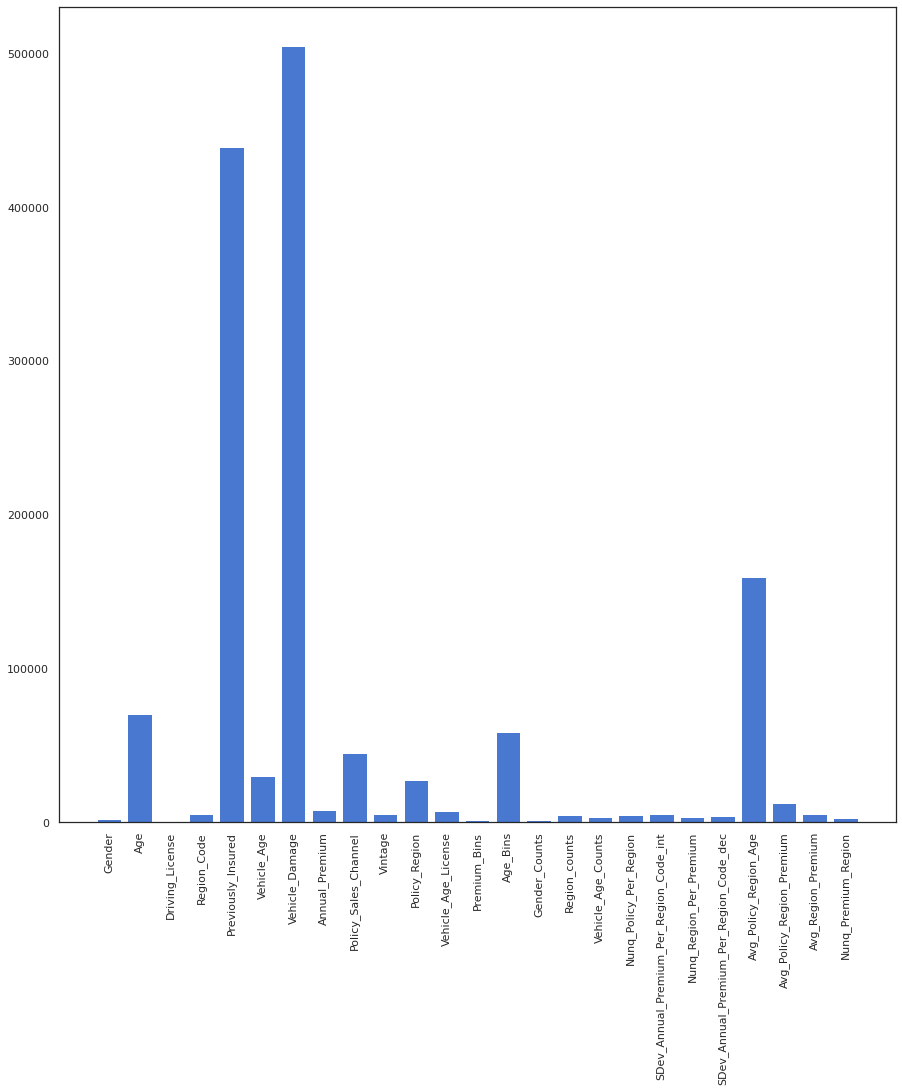

Fold 1
 rows of train = 251266 rows of holdout = 129441
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.281873	valid_0's auc: 0.85575
[200]	valid_0's binary_logloss: 0.268057	valid_0's auc: 0.859068
[300]	valid_0's binary_logloss: 0.264708	valid_0's auc: 0.859624
[400]	valid_0's binary_logloss: 0.263738	valid_0's auc: 0.859831
[500]	valid_0's binary_logloss: 0.26353	valid_0's auc: 0.859833
Early stopping, best iteration is:
[450]	valid_0's binary_logloss: 0.263595	valid_0's auc: 0.859868
LGB Val OOF AUC= 0.8598680563165642
####################################################################################################
Fold 2
 rows of train = 251266 rows of holdout = 129441
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds


In [37]:
%%time
##LightGBM

cat_features = ['Driving_License','Gender','Region_Code','Previously_Insured','Vehicle_Damage',
                'Policy_Sales_Channel','Policy_Region','Vehicle_Age','Vintage',
                'Annual_Premium','Vehicle_Age_License','Premium_Bins']

cont_features = ['Age','Age_Bins']

probs_lgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])

    X_train_cv,y_train_cv = train_df.copy(), target.copy()

    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = lgb.LGBMClassifier(boosting_type='gbdt',
                                 n_estimators=10000,
                                 max_depth=10,
                                 learning_rate=0.02,
                                 subsample=0.9,
                                 colsample_bytree=0.4,
                                 objective ='binary',
                                 random_state = 1,
                                 importance_type='gain',
                                 reg_alpha=2,
                                 reg_lambda=2
                                 #cat_features=cat_features
                                )        
        
        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['binary_logloss','auc'],
                    early_stopping_rounds=100)
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_lgb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)

        avg_loss.append(clf.best_score_['valid_0']['binary_logloss'])

        print ('LGB Val OOF AUC=',roc)

        print('#'*100)

        if i==0:
            feature_importance(clf,X_train_cv)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 251266 rows of holdout = 129441
[0]	validation_0-auc:0.83624	validation_0-logloss:0.66797
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85589	validation_0-logloss:0.27835
[200]	validation_0-auc:0.86012	validation_0-logloss:0.26459
[300]	validation_0-auc:0.86024	validation_0-logloss:0.26324
[400]	validation_0-auc:0.86019	validation_0-logloss:0.26317
Stopping. Best iteration:
[367]	validation_0-auc:0.86030	validation_0-logloss:0.26311

XGB Val OOF AUC= 0.8603039330841644
####################################################################################################
[0.00150885 0.009364   0.00262222 0.0015335  0.50267196 0.02257292
 0.37262085 0.00151683 0.00609644 0.00115978 0.00371489 0.0202001
 0.00113776 0.

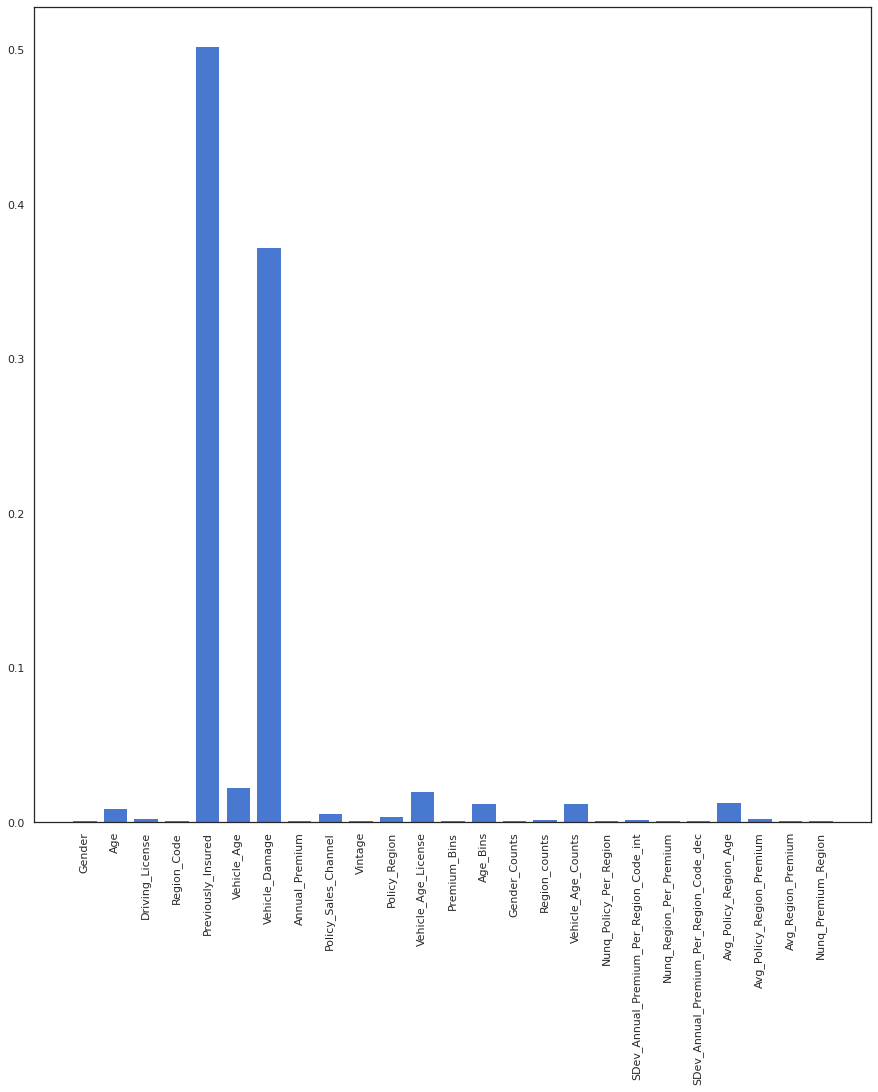

Fold 1
 rows of train = 251266 rows of holdout = 129441
[0]	validation_0-auc:0.83616	validation_0-logloss:0.66795
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85512	validation_0-logloss:0.27856
[200]	validation_0-auc:0.85972	validation_0-logloss:0.26486
[300]	validation_0-auc:0.85991	validation_0-logloss:0.26354
[400]	validation_0-auc:0.85979	validation_0-logloss:0.26351
Stopping. Best iteration:
[352]	validation_0-auc:0.85994	validation_0-logloss:0.26345

XGB Val OOF AUC= 0.859939409275201
####################################################################################################
Fold 2
 rows of train = 251266 rows of holdout = 129441
[0]	validation_0-auc:0.83594	validation_0-logloss:0.66794
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't im

In [38]:
%%time

##XGBM

probs_xgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = xgb.XGBClassifier(n_estimators=1000,
                                max_depth=6,
                                learning_rate=0.04,
                                subsample=0.9,
                                colsample_bytree=0.35,
                                objective = 'binary:logistic',
                                random_state = 1
                               )        


        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['auc','logloss'],
                    early_stopping_rounds=50)
        
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_xgb +=clf.predict_proba(test_df)[:,1]

        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)
        
        avg_loss.append(clf.best_score)

        print ('XGB Val OOF AUC=',roc)

        print('#'*100)

        if i==0:
            
            feature_importance(clf,X_train_cv)
            
print("Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.6f (%.6f)' % (np.array(scores).mean(), np.array(scores).std()))

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 251266 rows of holdout = 129441
0:	learn: 0.6546901	test: 0.6547381	best: 0.6547381 (0)	total: 410ms	remaining: 1h 8m 24s
100:	learn: 0.2667418	test: 0.2666153	best: 0.2666153 (100)	total: 27.8s	remaining: 45m 20s
200:	learn: 0.2633722	test: 0.2638318	best: 0.2638318 (200)	total: 56.2s	remaining: 45m 38s
300:	learn: 0.2621079	test: 0.2634245	best: 0.2634236 (299)	total: 1m 27s	remaining: 46m 55s
400:	learn: 0.2610910	test: 0.2632855	best: 0.2632855 (400)	total: 1m 59s	remaining: 47m 46s
500:	learn: 0.2601945	test: 0.2631967	best: 0.2631967 (500)	total: 2m 33s	remaining: 48m 37s
600:	learn: 0.2593548	test: 0.2631223	best: 0.2631223 (600)	total: 3m 8s	remaining: 49m 1s
700:	learn: 0.2585418	test: 0.2630640	best: 0.2630622 (692)	total: 3m 42s	remaining: 49m 11s
800:	learn: 0.2577751	test: 0.2630421	best: 0.2630421 (800)	total: 4m 17s	remaining: 49m 21s
900:

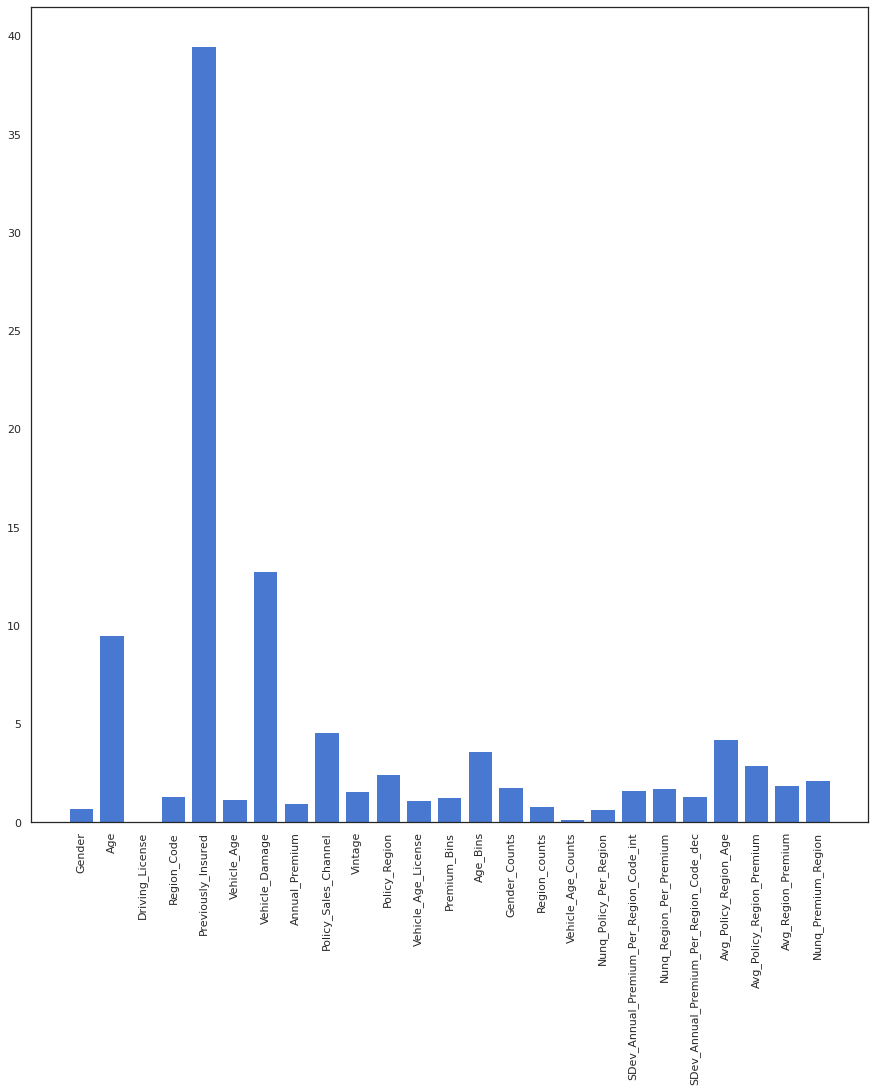

####################################################################################################
Fold 1
 rows of train = 251266 rows of holdout = 129441
0:	learn: 0.6534561	test: 0.6535466	best: 0.6535466 (0)	total: 345ms	remaining: 57m 33s
100:	learn: 0.2665255	test: 0.2668225	best: 0.2668225 (100)	total: 28.2s	remaining: 46m 6s
200:	learn: 0.2632253	test: 0.2641938	best: 0.2641938 (200)	total: 58.1s	remaining: 47m 10s
300:	learn: 0.2619371	test: 0.2638014	best: 0.2638014 (300)	total: 1m 29s	remaining: 48m 18s
400:	learn: 0.2609366	test: 0.2636791	best: 0.2636791 (400)	total: 2m 4s	remaining: 49m 48s
500:	learn: 0.2600571	test: 0.2635808	best: 0.2635808 (500)	total: 2m 40s	remaining: 50m 38s
600:	learn: 0.2592736	test: 0.2635331	best: 0.2635331 (600)	total: 3m 15s	remaining: 50m 57s
700:	learn: 0.2585227	test: 0.2635153	best: 0.2635153 (700)	total: 3m 51s	remaining: 51m 7s
800:	learn: 0.2577976	test: 0.2634876	best: 0.2634856 (782)	total: 4m 26s	remaining: 50m 55s
Stopped by overf

In [39]:
%%time

##CatBoost

cat_features = ['Driving_License','Gender','Region_Code','Previously_Insured','Vehicle_Damage',
                'Policy_Sales_Channel','Policy_Region','Vehicle_Age','Vintage','Annual_Premium',
                'Vehicle_Age_License','Premium_Bins']

cont_features = ['Age','Age_Bins']

probs_cb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = CatBoostClassifier(iterations=10000,
                                learning_rate=0.02,
                                random_strength=0.1,
                                depth=8,
                                loss_function='Logloss',
                                eval_metric='Logloss',
                                leaf_estimation_method='Newton',
                                random_state = 1,
                                cat_features =cat_features,
                                subsample = 0.9,
                                rsm = 0.8
                                )    

        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                   early_stopping_rounds=50,verbose = 100)

        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_cb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)

        print ('CatBoost Val OOF AUC=',roc)

        avg_loss.append(clf.best_score_['validation']['Logloss'])

        if i==0:
            
            feature_importance(clf,X_train_cv)

        print('#'*100)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))

In [40]:
p1 =probs_lgb/5

p2 = probs_cb/5

p3 = probs_xgb/5


In [41]:
submission = pd.read_csv('sample_submission.csv')

submission['Response'] =  0.7*p2+0.3*p3

In [42]:
submission.to_csv('submission.csv',index =False)

submission.head()

,id,Response
0,381110,0.000553
1,381111,0.300657
2,381112,0.294758
3,381113,0.007294
4,381114,0.000339
